In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Oct 31 08:32:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob

from matplotlib import pyplot as plt
from IPython.display import clear_output
from PIL import Image
import cv2

import os, random, gc
import re, time, json
import collections
from  ast import literal_eval
import ast

from tqdm.notebook import tqdm
import joblib

from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
DATA_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/signate_nihonbuyou")
INPUT = DATA_ROOT/"input"
OUTPUT = DATA_ROOT/"output"

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_all_seeds(2021)

画像データの読み込み

In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/signate_nihonbuyou/input/train.zip" .
#!cp -r "/content/drive/MyDrive/Colab Notebooks/signate_nihonbuyou/input/test.zip" .

In [ ]:
# ファイルの解凍
!unzip "/content/train.zip"
#!unzip "/content/test.zip"

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: train/not-hold/T4LBEMwrLdPMpan8pBowga.jpg  
  inflating: train/not-hold/T4Ri4D9EDTYpWLSPG5xBWU.jpg  
  inflating: train/not-hold/T4upqbvYSeKBy6GwXwz9qo.jpg  
  inflating: train/not-hold/T4VfrAc2VEnXR8tr6GvBry.jpg  
  inflating: train/not-hold/T4VNwXDByP2p5Hd5j2Rrbn.jpg  
  inflating: train/not-hold/T4WRv5j2BvtQUewwWgasF5.jpg  
  inflating: train/not-hold/T589vB3fre4dynWRxcFrhS.jpg  
  inflating: train/not-hold/T58MLZauQx5kETeBqLTVAq.jpg  
  inflating: train/not-hold/T5G5pHTt3uovTiQGHjNRwc.jpg  
  inflating: train/not-hold/T5h8CVRiiFSc9nRd9CsKUo.jpg  
  inflating: train/not-hold/T5JaRqwTNjuoZ3uvpZeuzN.jpg  
  inflating: train/not-hold/T5jdS2FL5J6hgjLdkWhrS2.jpg  
  inflating: train/not-hold/T5JtBPzjhMHstCG3SCEgKi.jpg  
  inflating: train/not-hold/T5PNnCLpokWg7Y6sEgeLCJ.jpg  
  inflating: train/not-hold/T5tfPjYg7ziykWxcCYou29.jpg  
  inflating: train/not-hold/T5u8k9KZRtckQ6PahbLR2g.jpg  
  inflating: train/not-hold/T5WBRaZVsigDQDYFVjtVom.jpg  

In [ ]:
TRAIN_HOLD_PATH = Path("/content/train/hold/")
TRAIN_NOTHOLD_PATH = Path("/content/train/not-hold/")

TEST_PATH = Path("/content/test")

ファイル名、パス、ラベル(目的変数)が対応付けられた表の作成

In [ ]:
classifications = ["not-hold", "hold"]

def search_images(directory):
    # 対応する画像の拡張子を定義
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    # 画像ファイルのパスとファイル名をリストに格納
    image_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                file_path = os.path.join(root, file)
                image_files.append({
                    'file_name': file,
                    'file_path': file_path
                })

    # pandas DataFrame に変換
    df = pd.DataFrame(image_files)

    return df

In [ ]:
INPUTS = Path("/content")

#画像のラベル付けをしたデータフレームを作成する。
train_df = pd.DataFrame()
train_df0 = search_images(TRAIN_NOTHOLD_PATH)
train_df1 = search_images(TRAIN_HOLD_PATH)
train_df0['caption'] = classifications[0]
train_df1['caption'] = classifications[1]
train_df0['label'] = 0
train_df1['label'] = 1
train_df = pd.concat([train_df0, train_df1], axis=0)
train_df=train_df.sample(frac=1, random_state=0)
train_df.reset_index(inplace=True, drop=True)
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/signate_nihonbuyou/output/train.csv', index=None)

train_df

,file_name,file_path,caption,label
0,gHRHoSY6LZSdnc4b3s8w2r.jpg,/content/train/not-hold/gHRHoSY6LZSdnc4b3s8w2r...,not-hold,0
1,BcLuQiHXfwNQf9CDdx8qty.jpg,/content/train/not-hold/BcLuQiHXfwNQf9CDdx8qty...,not-hold,0
2,kZGT2ELhuuC7BxWdtneWBs.jpg,/content/train/not-hold/kZGT2ELhuuC7BxWdtneWBs...,not-hold,0
3,cS8vKr74mbqFacCHyCiw8V.jpg,/content/train/not-hold/cS8vKr74mbqFacCHyCiw8V...,not-hold,0
4,2M2Gf6H9gYCtYxRjR7cdt5.jpg,/content/train/hold/2M2Gf6H9gYCtYxRjR7cdt5.jpg,hold,1
...,...,...,...,...
67441,a6jHvp7QeK2p5yMfmeJuXV.jpg,/content/train/hold/a6jHvp7QeK2p5yMfmeJuXV.jpg,hold,1
67442,d2VrYC43RQ5D2dXgexAwtD.jpg,/content/train/not-hold/d2VrYC43RQ5D2dXgexAwtD...,not-hold,0
67443,EgetXoVVJhAFS3BjXbhCNg.jpg,/content/train/hold/EgetXoVVJhAFS3BjXbhCNg.jpg,hold,1
67444,gkAs5Y6nAgXrhaxwPaip96.jpg,/content/train/hold/gkAs5Y6nAgXrhaxwPaip96.jpg,hold,1


諸々のインポート

In [ ]:
!pip install torcheval
!pip install timm
!pip install colorama

import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc
from torcheval.metrics.functional import binary_f1_score

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00


学習設定

In [ ]:
CONFIG = {
    "seed": 42,
    "epochs": 10,
    "img_size": 512,
    "model_name": "tf_efficientnet_b3",
    "checkpoint_path" : "/content/drive/MyDrive/Colab Notebooks/signate_nihonbuyou/output/model/tf_efficientnet_b3_aa-84b4657e.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 50,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [ ]:

CONFIG['T_max'] = train_df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']



16861

データのK層化分割を行うセル

In [ ]:
#K層化分割
def create_folds(df, num_splits, seed):
    df["kfold"] = -1

    mskf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=seed)
    labels = ["label"]
    df_labels = df[labels].values

#fは検証データにつくkfold番号、t_が訓練データ、v_が検証データ
    for f, (t_, v_) in enumerate(mskf.split(df, df_labels)):
        df.loc[v_, "kfold"] = f

    return df


train_df = create_folds(train_df, num_splits=CONFIG["n_fold"], seed=CONFIG["seed"])
print("Folds created successfully")

train_df.rename(columns={'label': 'target'}, inplace=True)

train_df.head(10)

Folds created successfully


,file_name,file_path,caption,target,kfold
0,gHRHoSY6LZSdnc4b3s8w2r.jpg,/content/train/not-hold/gHRHoSY6LZSdnc4b3s8w2r...,not-hold,0,1
1,BcLuQiHXfwNQf9CDdx8qty.jpg,/content/train/not-hold/BcLuQiHXfwNQf9CDdx8qty...,not-hold,0,2
2,kZGT2ELhuuC7BxWdtneWBs.jpg,/content/train/not-hold/kZGT2ELhuuC7BxWdtneWBs...,not-hold,0,4
3,cS8vKr74mbqFacCHyCiw8V.jpg,/content/train/not-hold/cS8vKr74mbqFacCHyCiw8V...,not-hold,0,2
4,2M2Gf6H9gYCtYxRjR7cdt5.jpg,/content/train/hold/2M2Gf6H9gYCtYxRjR7cdt5.jpg,hold,1,3
5,kYdjGP4UvGr3xjVRJEYtEq.jpg,/content/train/not-hold/kYdjGP4UvGr3xjVRJEYtEq...,not-hold,0,3
6,G7LZQq4J4BBy8jhxHhAjeN.jpg,/content/train/hold/G7LZQq4J4BBy8jhxHhAjeN.jpg,hold,1,1
7,DgGP8VEEf7t4hysTNX3XAW.jpg,/content/train/not-hold/DgGP8VEEf7t4hysTNX3XAW...,not-hold,0,1
8,bAwJg5xPK5fannroepjGoi.jpg,/content/train/hold/bAwJg5xPK5fannroepjGoi.jpg,hold,1,4
9,FHzsxX6StRyHf58o95Pwk8.jpg,/content/train/not-hold/FHzsxX6StRyHf58o95Pwk8...,not-hold,0,2


データセットの作成

In [ ]:
class nihonbuyouDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df_positive) * 2

    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]

        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }

class nihonbuyouDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }

画像の前処理、データ拡張

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Downscale(scale_range=(0.4,0.4),p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.15,
                           rotate_limit=60,
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

GeMプーリング

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

モデルの作成

In [ ]:
class nihonbuyouModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(nihonbuyouModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        #self.model = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output


model = nihonbuyouModel(CONFIG['model_name'], checkpoint_path=CONFIG['checkpoint_path'])
#model = nihonbuyouModel(CONFIG['model_name'])
model.to(CONFIG['device']);

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()

        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()

    return epoch_loss, epoch_auroc

In [ ]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])

    gc.collect()

    return epoch_loss, epoch_auroc

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CONFIG['device'], epoch=epoch)

        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'],
                                         epoch=epoch)

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )

        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "/content/drive/MyDrive/Colab Notebooks/signate_nihonbuyou/output/model/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'],
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'],
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    return scheduler

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = nihonbuyouDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = nihonbuyouDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'],
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                              num_workers=2, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

学習の実行

In [ ]:
train_loader, valid_loader = prepare_loaders(train_df, fold=CONFIG["fold"])

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

In [ ]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: NVIDIA A100-SXM4-40GB



100%|██████████| 211/211 [00:57<00:00,  3.66it/s, Epoch=1, LR=9.75e-5, Valid_Auroc=1, Valid_Loss=0.0234]


Validation AUROC Improved (-inf ---> 0.9996801618370303)
Model Saved



100%|██████████| 211/211 [00:57<00:00,  3.69it/s, Epoch=2, LR=9.01e-5, Valid_Auroc=0.999, Valid_Loss=0.0363]


 15%|█▍        | 254/1723 [01:36<09:16,  2.64it/s, Epoch=3, LR=8.87e-5, Train_Auroc=1, Train_Loss=0.0193]

結果のプロット

In [ ]:
history = pd.DataFrame.from_dict(history)
history.to_csv("/content/drive/MyDrive/Colab Notebooks/signate_nihonbuyou/output/history.csv", index=False)

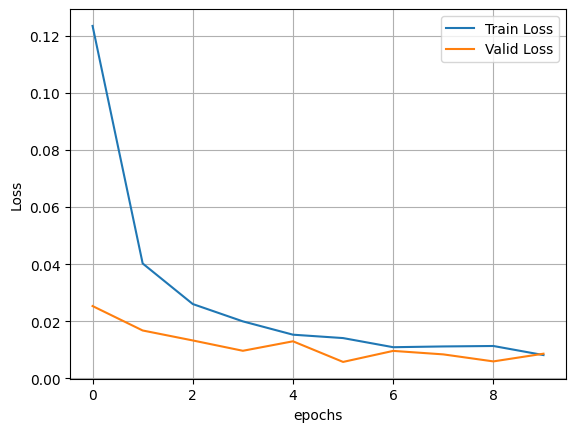

In [ ]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

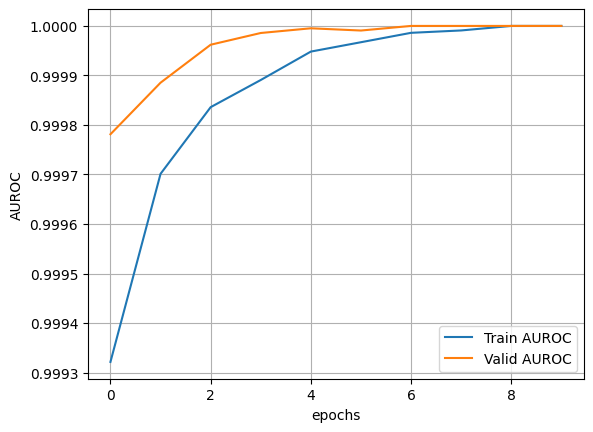

In [ ]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

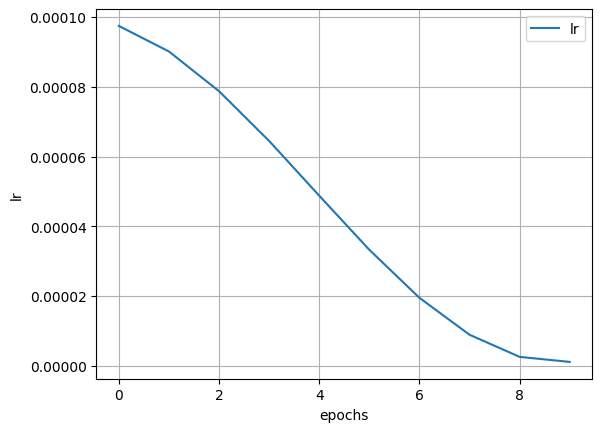

In [ ]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()

In [ ]:
img_shape = set()
img_ext = set()
img_names = list(train_df["file_path"])
pbar = tqdm(img_names, total=len(train_df))
for img_name in pbar:
    img = load_img(img_name.as_posix())
    img_shape.add(img.shape)
    img_ext.add(img_name.suffix)
print(f'Image shapes are {img_shape}.')
print(f'Image extensions are {img_ext}.')



  0%|          | 0/67446 [00:00<?, ?it/s]


NameError: name 'load_img' is not defined